In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
import random
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time

In [ ]:
n_way = 5
k_shot = 5
query_per_class = 1

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, in_channels=1):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        return x



In [ ]:
class RelationNetwork(nn.Module):
    def __init__(self, input_size=28, output_size=64):
        super(RelationNetwork, self).__init__()
        feature_size = input_size // 8

        self.conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)

        reduced_size = feature_size // 2

        self.fc1 = nn.Linear(64 * reduced_size * reduced_size, 8)
        self.fc2 = nn.Linear(8, 1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)


        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
class FewShotRelationNet(nn.Module):
    def __init__(self, in_channels=1, input_size=28):
        super(FewShotRelationNet, self).__init__()
        self.embedding_net = EmbeddingNet(in_channels)
        self.relation_net = RelationNetwork(input_size)
        self.input_size = input_size
        self.feature_size = input_size // 8

    def forward(self, support_set, query_set):
        n_examples = support_set.size(0)
        n_queries = query_set.size(0)

        support_features = self.embedding_net(support_set) #Dimensions: [25, 64, 3, 3]
        query_features = self.embedding_net(query_set) #Dimensions: [5, 64, 3, 3]

        support_features_ext = support_features.unsqueeze(0).repeat(n_queries, 1, 1, 1, 1)
        query_features_ext = query_features.unsqueeze(1).repeat(1, n_examples, 1, 1, 1)
        #Finally size is : [5, 25, 128, 3, 3]


        relations = torch.cat((support_features_ext, query_features_ext), dim=2)
        relations = relations.view(-1, 128, self.feature_size, self.feature_size) #relation_net accepts Dimensions:[batch size , channels , height , width]
        relations = self.relation_net(relations)
        relations = relations.view(n_queries, n_examples)

        return relations


In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, root_dir, transform=None, background=True):
        self.root_dir = root_dir
        self.transform = transform

        if background:
            self.character_folders = [os.path.join(root_dir, 'images_background', family, character)
                                     for family in os.listdir(os.path.join(root_dir, 'images_background'))
                                     for character in os.listdir(os.path.join(root_dir, 'images_background', family))]
        else:
            self.character_folders = [os.path.join(root_dir, 'images_evaluation', family, character)
                                     for family in os.listdir(os.path.join(root_dir, 'images_evaluation'))
                                     for character in os.listdir(os.path.join(root_dir, 'images_evaluation', family))]

        self.idx_to_class = {}
        self.samples = [] #(image path, class index) pairs
        self.targets = [] #label of the image

        for class_idx, folder in enumerate(self.character_folders):
            for sample_idx, filename in enumerate(os.listdir(folder)):
                if filename.endswith('.png'):
                    self.samples.append((os.path.join(folder, filename), class_idx))
                    self.targets.append(class_idx)
                    self.idx_to_class[len(self.samples) - 1] = (folder, class_idx)

        self.num_classes = len(self.character_folders)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
def prepare_omniglot(root_dir='./data/omniglot/'):
    from torchvision import transforms


    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    os.makedirs(root_dir, exist_ok=True)

    if not os.path.exists(os.path.join(root_dir, 'images_background')) or not os.path.exists(os.path.join(root_dir, 'images_evaluation')):
        print("Downloading Omniglot dataset...")
        import urllib.request
        import zipfile

        urllib.request.urlretrieve('https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
                                 os.path.join(root_dir, 'images_background.zip'))
        with zipfile.ZipFile(os.path.join(root_dir, 'images_background.zip'), 'r') as zip_ref:
            zip_ref.extractall(root_dir)

        urllib.request.urlretrieve('https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip',
                                 os.path.join(root_dir, 'images_evaluation.zip'))
        with zipfile.ZipFile(os.path.join(root_dir, 'images_evaluation.zip'), 'r') as zip_ref:
            zip_ref.extractall(root_dir)

    train_dataset = OmniglotDataset(root_dir=root_dir, transform=transform, background=True)
    test_dataset = OmniglotDataset(root_dir=root_dir, transform=transform, background=False)

    return train_dataset, test_dataset


In [ ]:
train_dataset, test_dataset = prepare_omniglot()

print(f"Training dataset size: {len(train_dataset)}, Number of classes: {train_dataset.num_classes}")
print(f"Testing dataset size: {len(test_dataset)}, Number of classes: {test_dataset.num_classes}")

Training dataset size: 19280, Number of classes: 964
Testing dataset size: 13180, Number of classes: 659


In [ ]:
def visualize_classes(dataset, num_classes=5, images_per_class=20):
    """Visualize images_per_class samples for num_classes different classes"""

    all_classes = list(set(dataset.targets))


    if len(all_classes) > num_classes:
        selected_classes = random.sample(all_classes, num_classes)
    else:
        selected_classes = all_classes[:num_classes]


    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(20, 12))

    for i, class_idx in enumerate(selected_classes):

        class_indices = [j for j, target in enumerate(dataset.targets) if target == class_idx]


        if len(class_indices) < images_per_class:
            sampled_indices = np.random.choice(class_indices, images_per_class, replace=True)
        else:
            sampled_indices = random.sample(class_indices, images_per_class)


        for j, idx in enumerate(sampled_indices):
            img, _ = dataset[idx]
            img_np = img.squeeze().numpy()

            axes[i, j].imshow(img_np, cmap='gray')
            if j == 0:
                axes[i, j].set_title(f"Class {class_idx}", fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Visualization of {images_per_class} Images for {num_classes} Classes", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()



Visualizing 20 images for 5 random classes of the Omniglot dataset:


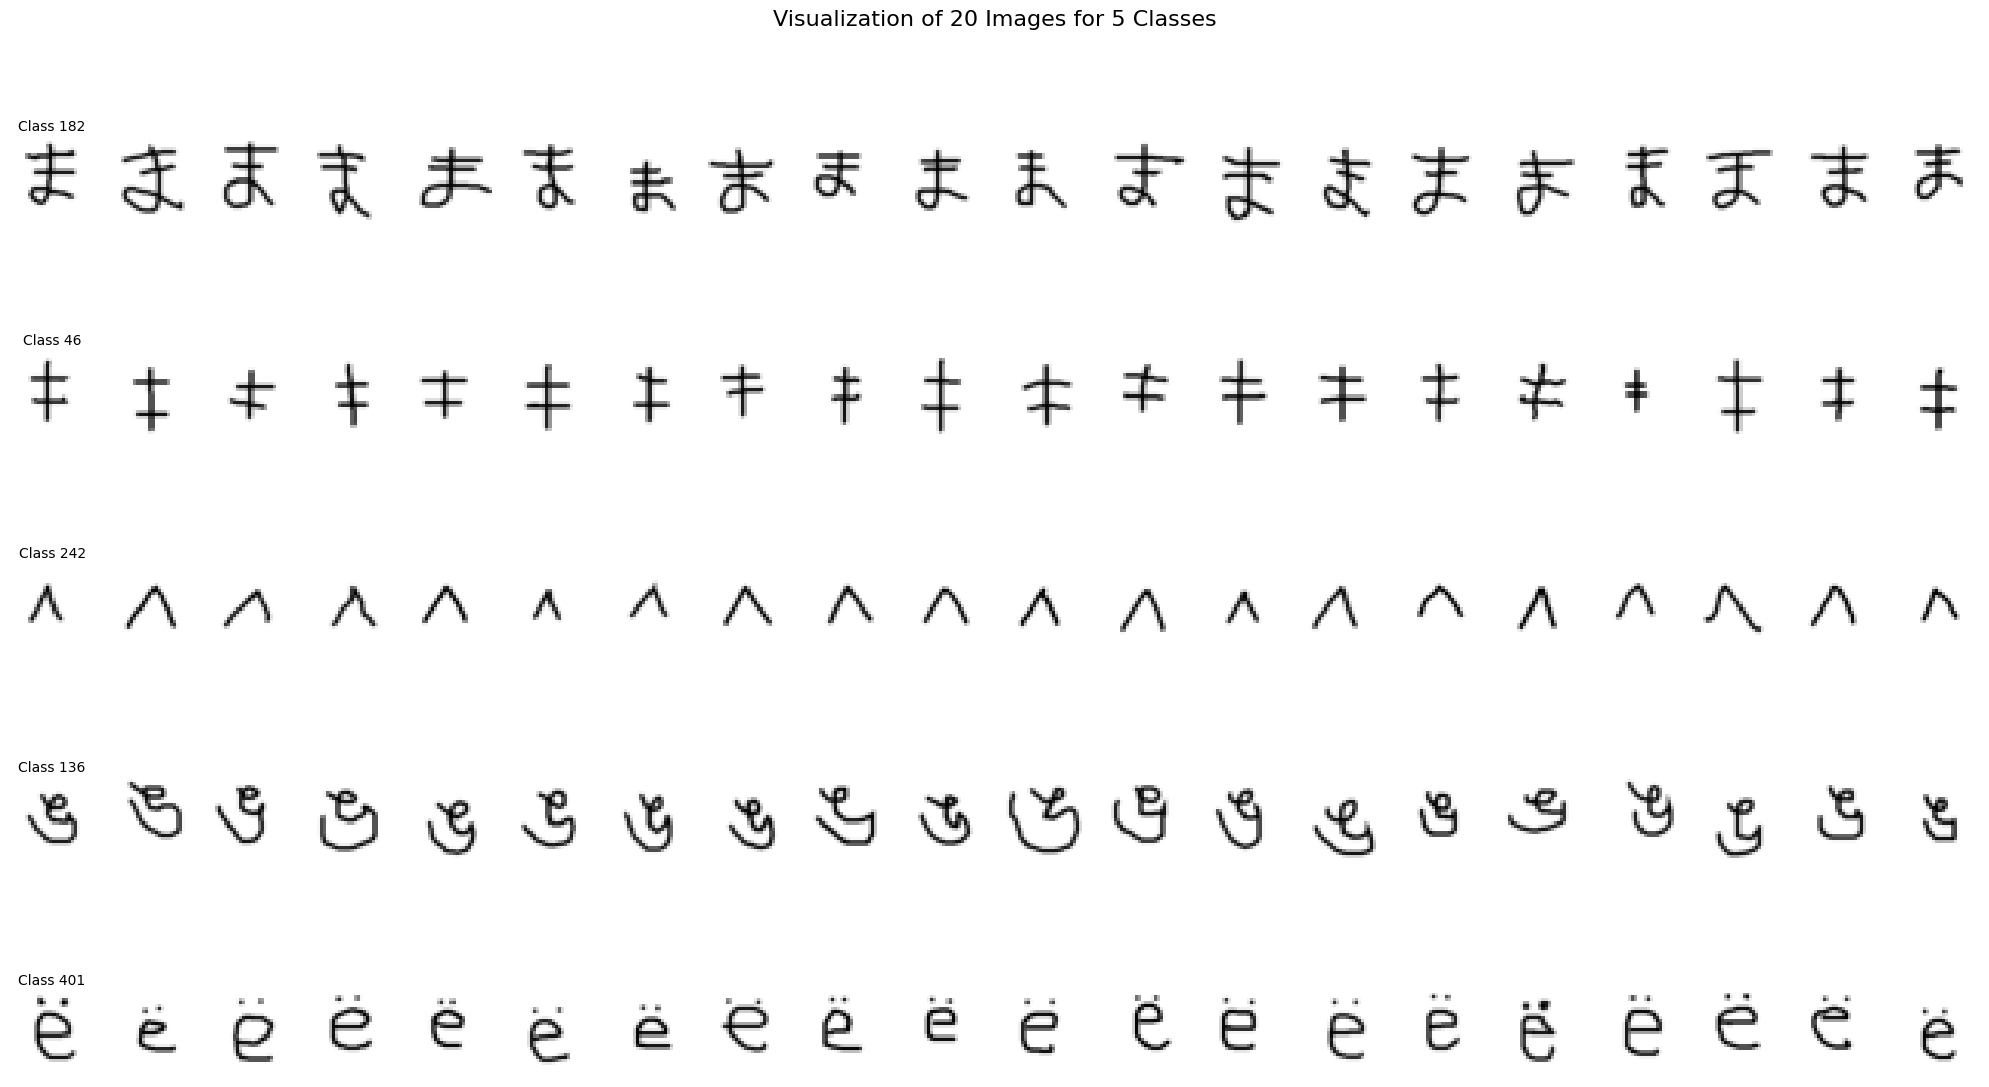

In [ ]:
print("\nVisualizing 20 images for 5 random classes of the Omniglot dataset:")
visualize_classes(train_dataset, num_classes=5, images_per_class=20)

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
model = FewShotRelationNet(in_channels=1, input_size=28).to(device)

In [ ]:
def create_episode(dataset, n_way, k_shot, query_per_class):

    targets = dataset.targets


    unique_classes = list(set(targets))


    n_way = min(n_way, len(unique_classes))


    selected_classes = random.sample(unique_classes, n_way)

    support_samples = []
    query_samples = []
    support_labels = []
    query_labels = []


    for i, cls in enumerate(selected_classes):

        class_indices = [j for j, target in enumerate(dataset.targets) if target == cls]           #storing where images are present for each class


        if len(class_indices) < (k_shot + query_per_class):
            selected_indices = np.random.choice(class_indices, k_shot + query_per_class, replace=True)
        else:
            selected_indices = np.random.choice(class_indices, k_shot + query_per_class, replace=False)

        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:(k_shot + query_per_class)]


        for idx in support_indices:
            img, _ = dataset[idx]
            support_samples.append(img)
            support_labels.append(i)


        for idx in query_indices:
            img, _ = dataset[idx]
            query_samples.append(img)
            query_labels.append(i)


    support_samples = torch.stack(support_samples)
    query_samples = torch.stack(query_samples)
    support_labels = torch.LongTensor(support_labels)
    query_labels = torch.LongTensor(query_labels)

    return support_samples, support_labels, query_samples, query_labels


In [ ]:
def visualize_episode(support_set, support_labels, query_set, query_labels, query_preds=None, title=None):
    n_way = len(torch.unique(support_labels))
    k_shot = len(support_set) // n_way
    n_query = len(query_set)


    fig_width = max(12, max(k_shot, n_query) * 2)
    fig_height = max(8, (n_way + 1) * 1.5)

    fig = plt.figure(figsize=(fig_width, fig_height))

    top_margin = 0.95 - 0.01 * n_way
    bottom_margin = 0.05 + 0.01 * n_way
    hspace = 0.5 + 0.02 * n_way

    gs = GridSpec(n_way + 1, max(k_shot, n_query), figure=fig)

    if title:
        plt.suptitle(title, fontsize=16)


    for i in range(n_way):
        for j in range(k_shot):
            idx = i * k_shot + j
            ax = fig.add_subplot(gs[i, j])
            img = support_set[idx].cpu().squeeze().numpy()
            ax.imshow(img, cmap='gray')
            if k_shot == 1:
                ax.set_title(f"Class {support_labels[idx].item()}", fontsize=8)
            else:
                ax.set_title(f"S{j+1}: Class {support_labels[idx].item()}", fontsize=8)
            ax.axis('off')


    for i in range(n_query):
        ax = fig.add_subplot(gs[n_way, i])
        img = query_set[i].cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        if query_preds is not None:
            if query_preds[i] == query_labels[i]:
                color = 'green'
                result = "✓"
            else:
                color = 'red'
                result = "✗"
            ax.set_title(f"Q: {query_labels[i].item()}, P: {query_preds[i].item()} {result}",
                         color=color, fontsize=9)
        else:
            ax.set_title(f"Query: {query_labels[i].item()}", fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=top_margin, bottom=bottom_margin, hspace=hspace, wspace=0.3)
    plt.show()


In [ ]:
def train(model, train_dataset, n_way, k_shot, query_per_class, device, num_episodes=1000, log_interval=10):

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    running_loss = 0.0


    episode_list = []
    accuracy_list = []
    loss_list = []

    for episode in range(num_episodes):
        model.train()
        optimizer.zero_grad()

        support_set, support_labels, query_set, query_labels = create_episode(
            train_dataset, n_way, k_shot, query_per_class)

        support_set = support_set.to(device)
        query_set = query_set.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        relations = model(support_set, query_set)             #computation of relational score

        one_hot_labels = torch.zeros(query_labels.size(0), n_way * k_shot).to(device)
        for i in range(query_labels.size(0)):
            for j in range(n_way * k_shot):
                if support_labels[j] == query_labels[i]:
                    one_hot_labels[i, j] = 1

        loss = F.mse_loss(relations, one_hot_labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        query_pred = torch.zeros(query_labels.size(0)).long().to(device)
        for i in range(query_labels.size(0)):
            support_relations = relations[i]
            class_relations = torch.zeros(n_way).to(device)
            for j in range(n_way):
                class_indices = [idx for idx, label in enumerate(support_labels) if label == j]
                if class_indices:
                    class_relations[j] = support_relations[class_indices].mean()
            query_pred[i] = class_relations.argmax()

        real_accuracy = (query_pred == query_labels).float().mean().item()

        if episode % log_interval == 0:
            avg_loss = running_loss / log_interval if running_loss > 0 else 0
            print(f"Episode {episode+1}/{num_episodes}, Loss: {avg_loss:.4f}, Accuracy: {real_accuracy:.4f}")

            episode_list.append(episode)
            accuracy_list.append(real_accuracy)
            loss_list.append(avg_loss)

            running_loss = 0.0


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 2)
    plt.plot(episode_list, loss_list, 'r-')
    plt.title('Training Loss Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    return model, episode_list, accuracy_list, loss_list

In [ ]:
def test(model, test_dataset, n_way, k_shot, query_per_class, device, num_episodes=100):
    model.eval()
    total_accuracy = 0.0

    episode_accuracies = []

    with torch.no_grad():
        for episode in range(num_episodes):
            support_set, support_labels, query_set, query_labels = create_episode(
                test_dataset, n_way, k_shot, query_per_class)

            support_set = support_set.to(device)
            query_set = query_set.to(device)
            support_labels = support_labels.to(device)
            query_labels = query_labels.to(device)

            relations = model(support_set, query_set)

            query_pred = torch.zeros(query_labels.size(0)).long().to(device)
            for i in range(query_labels.size(0)):
                support_relations = relations[i]
                class_relations = torch.zeros(n_way).to(device)
                for j in range(n_way):
                    class_indices = [idx for idx, label in enumerate(support_labels) if label == j]         # checking where selected class images are in support images
                    if class_indices:
                        class_relations[j] = support_relations[class_indices].mean()
                query_pred[i] = class_relations.argmax()

            accuracy = (query_pred == query_labels).float().mean().item()
            episode_accuracies.append(accuracy)
            total_accuracy += accuracy


    avg_accuracy = total_accuracy / num_episodes
    print(f"Average test accuracy ({n_way}-way {k_shot}-shot) over {num_episodes} episodes: {avg_accuracy:.4f}")

    return avg_accuracy, episode_accuracies


In [ ]:
def test_different_configs(model, test_dataset, device):

    configs = [
        (5, 1),
        (5, 5),
        (10, 5),
    ]

    results = {}

    for n_way, k_shot in configs:
        print(f"\nTesting {n_way}-way {k_shot}-shot configuration:")

        model.eval()
        total_accuracy = 0.0
        episode_accuracies = []

        with torch.no_grad():

            num_episodes = 10
            for episode in range(num_episodes):
                support_set, support_labels, query_set, query_labels = create_episode(
                    test_dataset, n_way=n_way, k_shot=k_shot, query_per_class=1)

                support_set = support_set.to(device)
                query_set = query_set.to(device)
                support_labels = support_labels.to(device)
                query_labels = query_labels.to(device)

                relations = model(support_set, query_set)

                query_pred = torch.zeros(query_labels.size(0)).long().to(device)
                for i in range(query_labels.size(0)):
                    support_relations = relations[i]
                    class_relations = torch.zeros(n_way).to(device)
                    for j in range(n_way):
                        class_indices = [idx for idx, label in enumerate(support_labels) if label == j]
                        if class_indices:
                            class_relations[j] = support_relations[class_indices].mean()
                    query_pred[i] = class_relations.argmax()

                accuracy = (query_pred == query_labels).float().mean().item()
                episode_accuracies.append(accuracy)
                total_accuracy += accuracy


                if episode == 0:
                    visualize_episode(
                        support_set.cpu(),
                        support_labels.cpu(),
                        query_set.cpu(),
                        query_labels.cpu(),
                        query_pred.cpu(),
                        title=f"Test Example: {n_way}-way {k_shot}-shot"
                    )

        avg_accuracy = total_accuracy / num_episodes
        print(f"Average test accuracy ({n_way}-way {k_shot}-shot) over {num_episodes} episodes: {avg_accuracy:.4f}")
        results[(n_way, k_shot)] = avg_accuracy

    print("\nSummary of Different Configurations:")
    print("-" * 40)
    print(f"{'Configuration':<20} {'Accuracy':<10}")
    print("-" * 40)
    for (n_way, k_shot), accuracy in results.items():
        print(f"{n_way}-way {k_shot}-shot{'':<10} {accuracy:.4f}")

    return results



Starting 5-way 5-shot training on Omniglot for 1000 episodes...
Episode 1/1000, Loss: 0.0530, Accuracy: 0.2000
Episode 6/1000, Loss: 0.2556, Accuracy: 0.4000
Episode 11/1000, Loss: 0.2401, Accuracy: 0.4000
Episode 16/1000, Loss: 0.2279, Accuracy: 0.4000
Episode 21/1000, Loss: 0.2187, Accuracy: 0.6000
Episode 26/1000, Loss: 0.2098, Accuracy: 0.4000
Episode 31/1000, Loss: 0.1967, Accuracy: 0.6000
Episode 36/1000, Loss: 0.1940, Accuracy: 1.0000
Episode 41/1000, Loss: 0.1913, Accuracy: 0.6000
Episode 46/1000, Loss: 0.1731, Accuracy: 0.8000
Episode 51/1000, Loss: 0.1727, Accuracy: 0.6000
Episode 56/1000, Loss: 0.1633, Accuracy: 0.6000
Episode 61/1000, Loss: 0.1701, Accuracy: 0.2000
Episode 66/1000, Loss: 0.1660, Accuracy: 0.4000
Episode 71/1000, Loss: 0.1615, Accuracy: 0.4000
Episode 76/1000, Loss: 0.1574, Accuracy: 0.4000
Episode 81/1000, Loss: 0.1516, Accuracy: 0.6000
Episode 86/1000, Loss: 0.1413, Accuracy: 0.8000
Episode 91/1000, Loss: 0.1365, Accuracy: 0.8000
Episode 96/1000, Loss: 0.

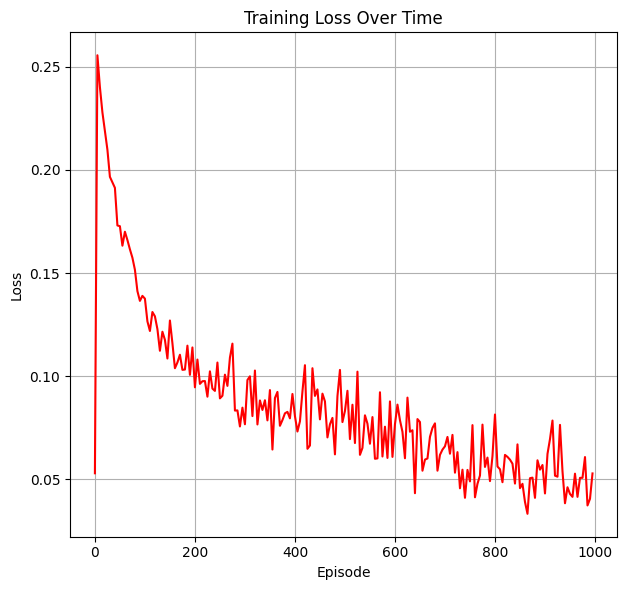


Testing 5-way 1-shot configuration:


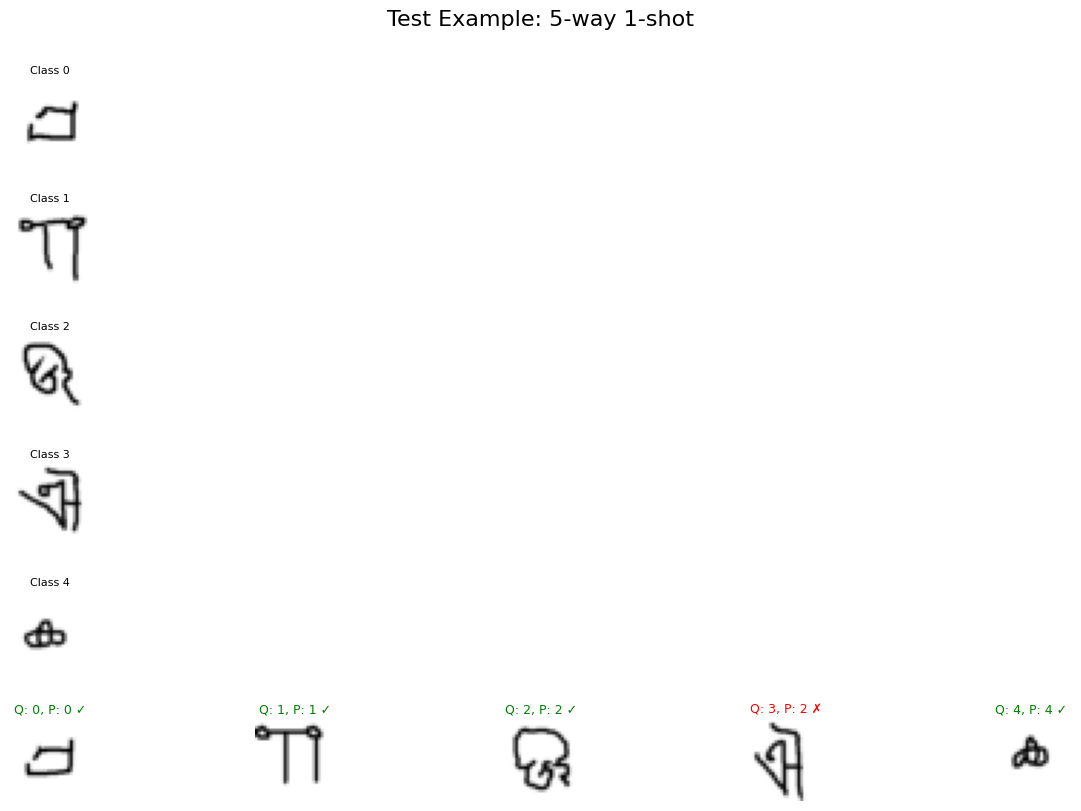

Average test accuracy (5-way 1-shot) over 10 episodes: 0.8000

Testing 5-way 5-shot configuration:


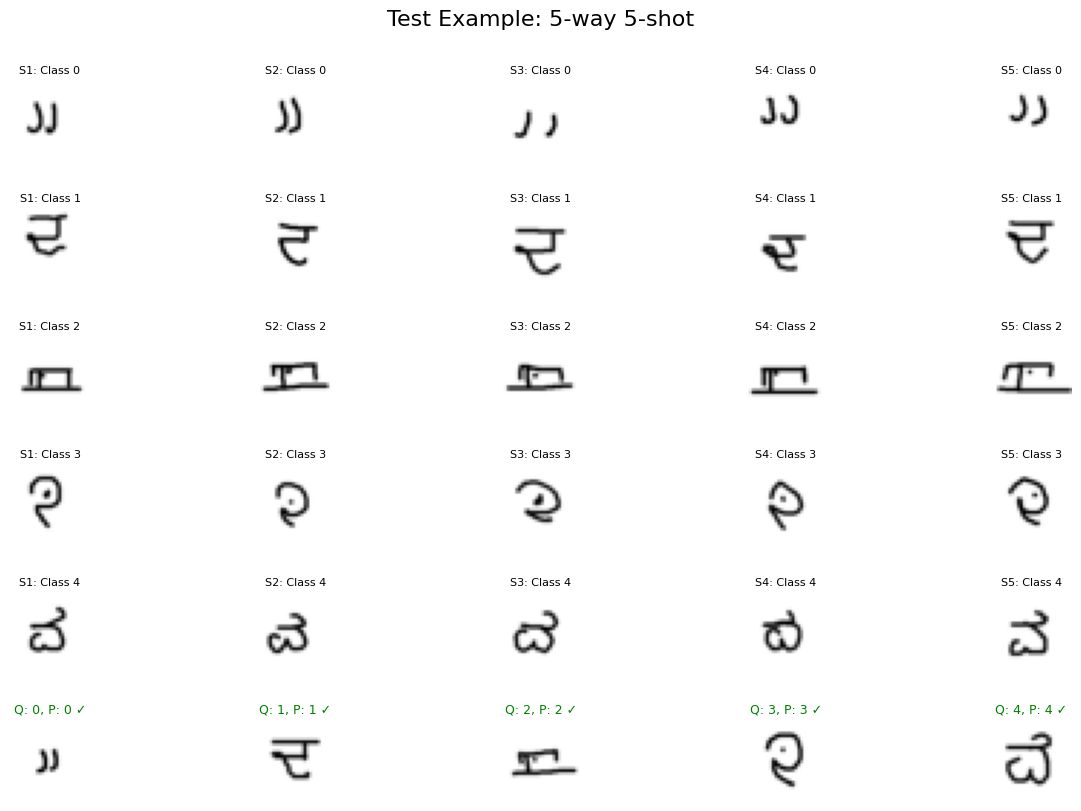

Average test accuracy (5-way 5-shot) over 10 episodes: 0.9000

Testing 10-way 5-shot configuration:


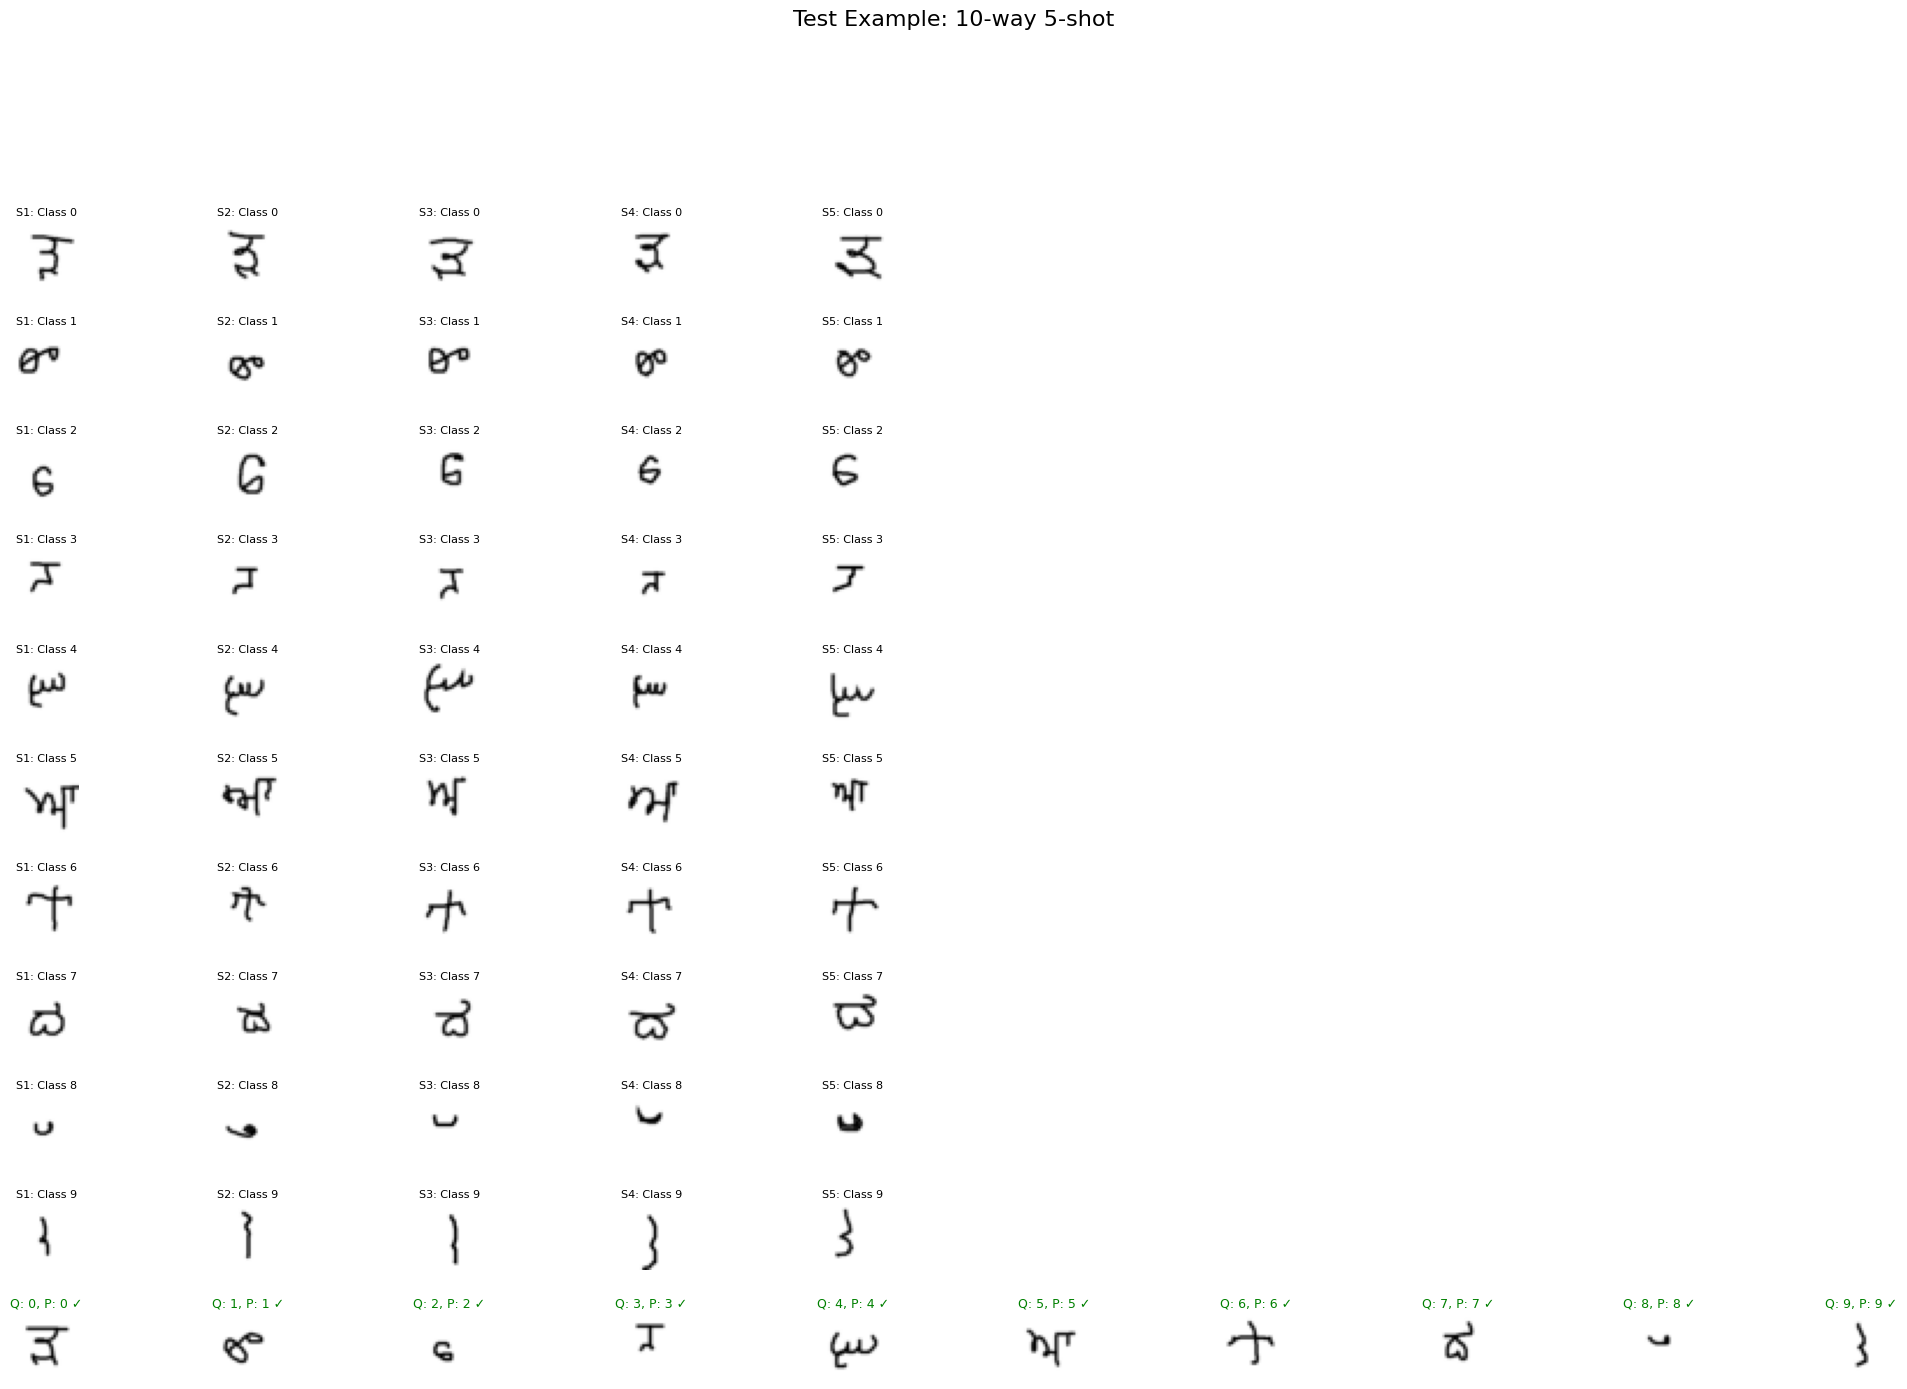

Average test accuracy (10-way 5-shot) over 10 episodes: 0.8600

Summary of Different Configurations:
----------------------------------------
Configuration        Accuracy  
----------------------------------------
5-way 1-shot           0.8000
5-way 5-shot           0.9000
10-way 5-shot           0.8600


In [ ]:

    num_episodes = 1000
    learning_rate = 0.001

    print(f"\nStarting {n_way}-way {k_shot}-shot training on Omniglot for {num_episodes} episodes...")
    model, episode_list, accuracy_list, loss_list = train(
        model, train_dataset, n_way=n_way, k_shot=k_shot,
        query_per_class=query_per_class, device=device,
        num_episodes=num_episodes, log_interval=5
    )


    config_results = test_different_configs(model, test_dataset, device)